In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import glob, os
import pandas as pd
from dask import delayed
from solardatatools import DataHandler
from sdt_dask.dataplugs.pvdaq_plug import PVDAQPlug
from sdt_dask.clients.aws.fargate import Fargate

# User defined env variables, configuration for the Fargate Cluster

In [4]:
# The Tag, VPC, image, workers, threads per worker and environment need to be user defined and passed to the client class
PA_NUMBER = os.getenv("project-pa-number")
TAGS = {
    "project-pa-number": PA_NUMBER,
    "project": "pvinsight"
}
VPC = "vpc-ab2ff6d3" # for us-west-2
IMAGE = "nimishy/sdt-dask-windows:latest"

AWS_DEFAULT_REGION = os.getenv('AWS_DEFAULT_REGION')
ENVIRONMENT = {
    'AWS_ACCESS_KEY_ID' : os.getenv('AWS_ACCESS_KEY_ID'),
    'AWS_SECRET_ACCESS_KEY' : os.getenv('AWS_SECRET_ACCESS_KEY')
}

WORKERS = 3
THREADS_PER_WORKER = 1

# Import user-defined dataplug

## Pull from PVDAQ

In [5]:
PVDAQPlug?

Init signature: PVDAQPlug(api_key='DEMO_KEY', power_col='ac_power')
Docstring:     
Dataplug class for retrieving data from the PVDAQ DB.
Note that the DEMO_KEY has a rate limit of 30/h, 50/d per IP address.
File:           c:\users\zander\documents\slac\solar-data-tools-develop-dask\sdt_dask\dataplugs\pvdaq_plug.py
Type:           type
Subclasses:     

In [6]:
data_plug = PVDAQPlug()

In [7]:
KEYS = [(34, 2011), (35, 2015), (51,2012)] # site ID and year pairs
KEYS

[(34, 2011), (35, 2015), (51, 2012)]

# Create SDT Dask task graph (run in parallel on multiple files)

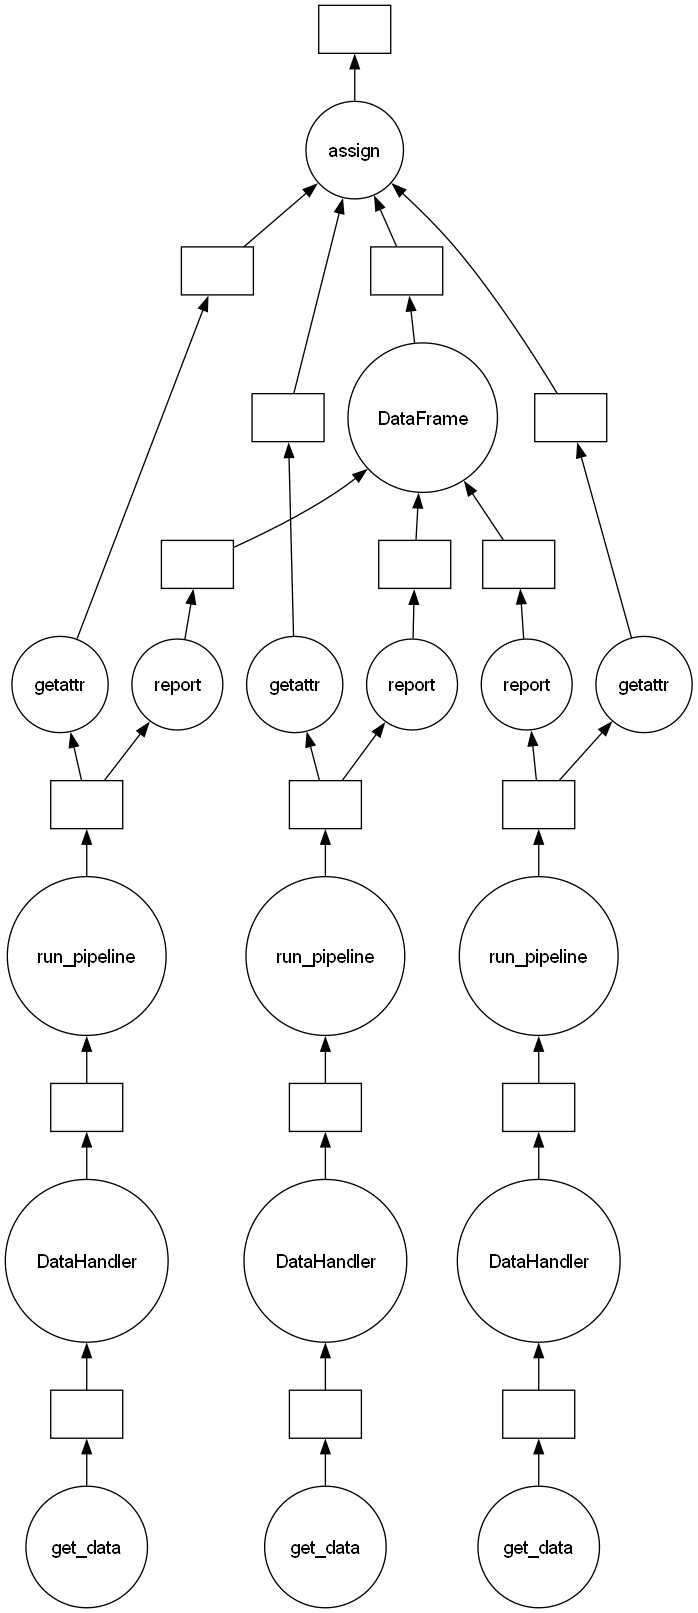

In [8]:
# Define the pipeline run for as single dataset
def run_pipeline(datahandler, solver, solver_convex, verbose=False):
    # Need to call this separately to have it run correctly in task graph 
    # since it doesn't return anything
    datahandler.run_pipeline(solver=solver, solver_convex=solver_convex, verbose=verbose)
    return datahandler


# Call above functions in a for loop over the keys
# and collect results in a DataFrame
reports = []
runtimes = []

for key in KEYS:
    
    df = delayed(data_plug.get_data)(key)
    dh = delayed(DataHandler)(df)
    dh_run = delayed(run_pipeline)(dh, solver="OSQP", solver_convex="OSQP", verbose=True)
    report = dh_run.report
    runtime = dh_run.total_time
    
    report = delayed(report)(return_values=True, verbose=False)
    runtime = delayed(runtime)
    
    reports.append(report)
    runtimes.append(runtime)


df_reports = delayed(pd.DataFrame)(reports)
df_reports = delayed(df_reports.assign)(runtime=runtimes, keys=KEYS)

# Visualizing the graph
df_reports.visualize()

# Get User-defined Client
## AWS Fargate


In [9]:
client = Fargate().init_client(image=IMAGE, 
                               tags=TAGS, 
                               vpc=VPC, 
                               region_name=AWS_DEFAULT_REGION,
                               environment=ENVIRONMENT,
                               n_workers=WORKERS,
                               threads_per_worker=THREADS_PER_WORKER
                               )

[i] Initilializing Fargate Cluster ...


c:\Users\Zander\anaconda3\envs\pvi-user\lib\contextlib.py:142: UserWarning: Creating your cluster is taking a surprisingly long time. This is likely due to pending resources on AWS. Hang tight! 
  next(self.gen)


[i] Initilializing Dask Client ...
[>] Dask Dashboard: http://35.87.62.93:8787/status


# Compute pipelines on client

In [10]:
summary_table = client.compute(df_reports)

In [11]:
summary_table

<Future: pending, key: assign-8424b210-f90a-49b5-a31f-1b506fa94778>

# Resulting pipeline reports

In [12]:
summary_table.result()

,length,capacity,sampling,quality score,clearness score,inverter clipping,clipped fraction,capacity change,data quality warning,time shift correction,time zone correction,runtime,keys
0,1.00000,109.30000,15,0.983562,0.498630,True,0.016438,False,False,False,0,8.919838,"(34, 2011)"
1,1.00000,80.00000,15,0.279452,0.123288,True,0.019178,False,True,False,0,5.844592,"(35, 2015)"
2,1.00274,5.20357,15,0.975410,0.234973,True,0.016393,False,True,False,0,10.080115,"(51, 2012)"


In [13]:
client.shutdown()